In [1]:
import numpy as np

import array, random, time, copy
from deap import base, creator, benchmarks, tools, algorithms
import time

from matplotlib import cm
import matplotlib.pyplot as plt

random.seed(42)

In [2]:
import seaborn as sns

sns.set(style='whitegrid')
sns.set_context('notebook')

definição de plots

In [3]:
def plot_problem_3d(problem, bounds, resolution=100., 
                    cmap=cm.viridis_r, rstride=10, cstride=10, 
                    linewidth=0.15, alpha=0.65, ax=None):
    'Plots a given deap benchmark problem in 3D mesh.'
    (minx,miny),(maxx,maxy) = bounds
    x_range = np.arange(minx, maxx, (maxx-minx)/resolution)
    y_range = np.arange(miny, maxy, (maxy-miny)/resolution)
    
    X, Y = np.meshgrid(x_range, y_range)
    Z = np.zeros((len(x_range), len(y_range)))
    
    for i in range(len(x_range)):
        for j in range(len(y_range)):
            Z[i,j] = problem((x_range[i], y_range[j]))[0]
    
    if not ax:
        fig = plt.figure(figsize=(11,6))
        ax = fig.gca(projection='3d')
        
    cset = ax.plot_surface(X, Y, Z, cmap=cmap, rstride=rstride,
                           cstride=cstride, linewidth=linewidth,
                           alpha=alpha)

In [4]:
def plot_problem_controur(problem, bounds, optimum=None,
                          resolution=100., cmap=cm.viridis_r, 
                          rstride=1, cstride=10, linewidth=0.15,
                          alpha=0.65, ax=None):
    'Plots a given deap benchmark problem as a countour plot'
    (minx,miny),(maxx,maxy) = bounds
    x_range = np.arange(minx, maxx, (maxx-minx)/resolution)
    y_range = np.arange(miny, maxy, (maxy-miny)/resolution)
    
    X, Y = np.meshgrid(x_range, y_range)
    Z = np.zeros((len(x_range), len(y_range)))
    
    for i in range(len(x_range)):
        for j in range(len(y_range)):
            Z[i,j] = problem((x_range[i], y_range[j]))[0]
    
    if not ax:
        fig = plt.figure(figsize=(6,6))
        ax = fig.gca()
        ax.set_aspect('equal')
        ax.autoscale(tight=True)
    
    cset = ax.contourf(X, Y, Z, cmap=cmap, rstride=rstride, 
                       cstride=cstride, linewidth=linewidth, 
                       alpha=alpha)
    
    if optimum:
        ax.plot(optimum[0], optimum[1], 'bx', 
                linewidth=4, markersize=15)

In [5]:
def plot_cov_ellipse(pos, cov, volume=.99, ax=None, fc='lightblue', ec='darkblue', alpha=1, lw=1):
    ''' Plots an ellipse that corresponds to a bivariate normal distribution.
    Adapted from http://www.nhsilbert.net/source/2014/06/bivariate-normal-ellipse-plotting-in-python/'''
    from scipy.stats import chi2
    from matplotlib.patches import Ellipse

    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    kwrg = {'facecolor':fc, 'edgecolor':ec, 'alpha':alpha, 
            'linewidth':lw}

    # Width and height are "full" widths, not radius
    width, height = 2 * np.sqrt(chi2.ppf(volume,2)) * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, 
                    angle=theta, **kwrg)
    ax.add_artist(ellip)

Benchmarks

$$\text{Esfera:  } f(\mathbf{x}) = \sum_{i=0}^{N-1}x_i^2 $$

In [6]:
current_problem = benchmarks.sphere

In [7]:
search_space_dims = 2 # we want to plot the individuals so this must be 2

MIN_VALUE, MAX_VALUE = -100., 100.
MIN_STRAT, MAX_STRAT = 0.0000001, 1. 

In [8]:
# We are facing a minimization problem
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# Evolutionary strategies need a location (mean)
creator.create("Individual", array.array, typecode='d', 
               fitness=creator.FitnessMin, strategy=None)
# ...and a value of the strategy parameter.
creator.create("Strategy", array.array, typecode="d")

In [9]:
def init_univariate_es_ind(individual_class, strategy_class,
                           size, min_value, max_value, 
                           min_strat, max_strat):
    ind = individual_class(random.uniform(min_value, max_value) 
                           for _ in range(size))
    # we modify the instance to include the strategy in run-time.
    ind.strategy = strategy_class(random.uniform(min_strat, max_strat) for _ in range(size))
    return ind

In [10]:
toolbox = base.Toolbox() 
toolbox.register("individual", init_univariate_es_ind, 
                 creator.Individual, 
                 creator.Strategy,
                 search_space_dims, 
                 MIN_VALUE, MAX_VALUE, 
                 MIN_STRAT, MAX_STRAT)
toolbox.register("population", tools.initRepeat, list, 
                 toolbox.individual)

In [11]:
ind = toolbox.individual()
pop = toolbox.population(n=50)

In [12]:
def plot_individual(individual, ax=None):
    'Plots an ES indiviual as center and 3*sigma ellipsis.'
    cov = np.eye(len(individual)) * individual.strategy
    plot_cov_ellipse(individual, cov, volume=0.99, alpha=0.56, ax=ax)
    if ax:
        ax.scatter(individual[0], individual[1], 
                    marker='+', color='k', zorder=100)
    else:
        plt.scatter(individual[0], individual[1], 
                    marker='+', color='k', zorder=100)

    
def plot_population(pop, gen=None, max_gen=None, ax=None):
    if gen:
        plt.subplot(max_gen, 1, gen)
        
    for ind in pop:
        plot_individual(ind, ax)

In [13]:
toolbox.register("mutate", tools.mutESLogNormal, c=1, indpb=0.1)

In [14]:
toolbox.register("mate", tools.cxESBlend, alpha=0.1)
toolbox.register("evaluate", current_problem)
toolbox.register("select", tools.selBest)

In [15]:
#mu_es, lambda_es = 50,100
n=10
pop = toolbox.population(n=n)
hof = tools.HallOfFame(1)

<ipython-input-4-ff0702af06c4>:23: UserWarning: The following kwargs were not used by contour: 'rstride', 'cstride', 'linewidth'
  cset = ax.contourf(X, Y, Z, cmap=cmap, rstride=rstride,


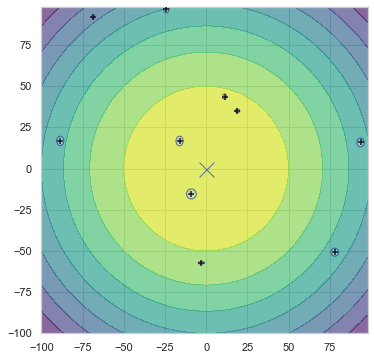

In [16]:
plot_problem_controur(current_problem, ((-100,-100), (100,100)), 
                      optimum=(0,0))
plot_population(pop)

In [17]:
#pop_stats = tools.Statistics(key=copy.deepcopy)
#pop_stats.register('pop', copy.deepcopy)

stats = tools.Statistics(lambda ind: ind.fitness.values)
# -- copies the populations themselves

In [18]:

stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

start_time=time.time()
pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=n, 
                                         lambda_=n, cxpb=.6,
                                         mutpb=.3, ngen=50, 
                                         stats=stats, 
                                         halloffame=hof, verbose=True)
time_n10=time.time()-start_time

gen	nevals	avg            	std            	min           	max             
0  	10    	[5679.54775343]	[4384.14910942]	[318.08376892]	[13186.78134359]
1  	8     	[1857.46031985]	[1538.77070232]	[318.08376892]	[5677.3580951]  
2  	9     	[727.42218113] 	[446.06020859] 	[160.0541839] 	[1348.00337595] 
3  	9     	[293.09109229] 	[143.00343032] 	[15.34424044] 	[541.02665191]  
4  	10    	[185.85920275] 	[98.6522795]   	[15.34424044] 	[318.08376892]  
5  	10    	[84.34793959]  	[55.00070056]  	[15.34424044] 	[143.19131189]  
6  	8     	[44.08239923]  	[30.4166013]   	[15.34424044] 	[101.33853676]  
7  	10    	[21.53572953]  	[8.37758337]   	[15.34424044] 	[40.58566633]   
8  	10    	[15.34424044]  	[1.12346671e-15]	[15.34424044] 	[15.34424044]   
9  	9     	[15.34424044]  	[1.12346671e-15]	[15.34424044] 	[15.34424044]   
10 	10    	[15.34424044]  	[1.58882186e-15]	[15.34424044] 	[15.34424044]   
11 	9     	[15.34424044]  	[2.24693342e-15]	[15.34424044] 	[15.34424044]   
12 	10    	[15.344240

In [19]:
time_n10

0.04685688018798828

<ipython-input-4-ff0702af06c4>:23: UserWarning: The following kwargs were not used by contour: 'rstride', 'cstride', 'linewidth'
  cset = ax.contourf(X, Y, Z, cmap=cmap, rstride=rstride,


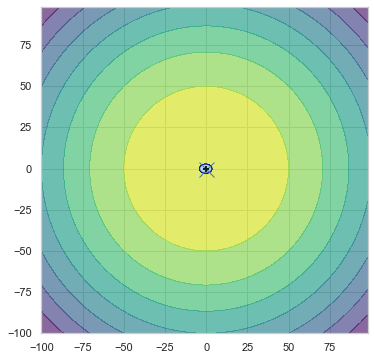

In [20]:
plot_problem_controur(current_problem, ((-100,-100), (100,100)),
                      optimum=(0,0))
plot_population(pop)

<ipython-input-4-ff0702af06c4>:23: UserWarning: The following kwargs were not used by contour: 'rstride', 'cstride', 'linewidth'
  cset = ax.contourf(X, Y, Z, cmap=cmap, rstride=rstride,


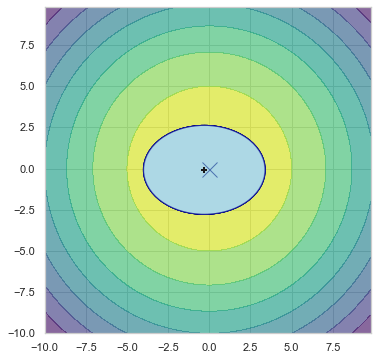

In [21]:
plot_problem_controur(current_problem, ((-10,-10), (10,10)), 
                      optimum=(0,0))
plot_population(pop)

<ipython-input-4-ff0702af06c4>:23: UserWarning: The following kwargs were not used by contour: 'rstride', 'cstride', 'linewidth'
  cset = ax.contourf(X, Y, Z, cmap=cmap, rstride=rstride,


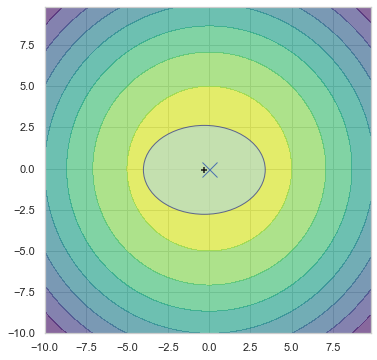

In [22]:
plot_problem_controur(current_problem, ((-10,-10), (10,10)), 
                      optimum=(0,0))
plot_population(hof)

In [23]:
n=50
pop = toolbox.population(n=n)
hof = tools.HallOfFame(1)
start_time=time.time()

pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=n, 
                                         lambda_=n, cxpb=.6,
                                         mutpb=.3, ngen=50, 
                                         stats=stats, 
                                         halloffame=hof, verbose=True)
time_n50=time.time()-start_time

gen	nevals	avg            	std            	min           	max             
0  	50    	[5900.53715034]	[3947.05148146]	[551.41018492]	[14631.32205902]
1  	46    	[1989.8143455] 	[1091.03245071]	[75.36482411] 	[4511.85886954] 
2  	42    	[1027.24863199]	[466.66750921] 	[75.36482411] 	[1752.4927958]  
3  	45    	[575.82632975] 	[318.04854009] 	[49.95214621] 	[941.99786592]  
4  	48    	[274.75933908] 	[197.44287877] 	[12.33855332] 	[594.27085116]  
5  	47    	[82.41591457]  	[40.42363929]  	[12.33855332] 	[177.50028132]  
6  	44    	[39.4442477]   	[20.26601284]  	[1.70341829]  	[75.36482411]   
7  	47    	[18.04210362]  	[10.55501524]  	[1.21518656]  	[34.4564796]    
8  	46    	[6.70987194]   	[3.93115278]   	[0.41959391]  	[13.74734721]   
9  	45    	[2.87004877]   	[1.47287836]   	[0.38941765]  	[5.18799568]    
10 	48    	[1.41458008]   	[0.71070756]   	[0.07537806]  	[2.66039791]    
11 	43    	[0.56824959]   	[0.31847979]   	[0.01141093]  	[1.21518656]    
12 	37    	[0.28360255]  

In [24]:
time_n50

0.1075589656829834

<ipython-input-4-ff0702af06c4>:23: UserWarning: The following kwargs were not used by contour: 'rstride', 'cstride', 'linewidth'
  cset = ax.contourf(X, Y, Z, cmap=cmap, rstride=rstride,


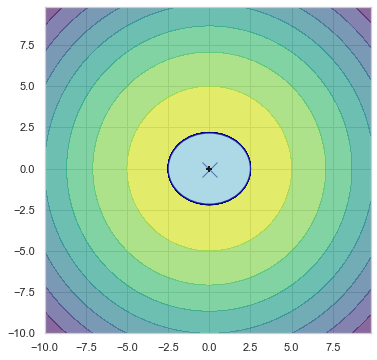

In [25]:
plot_problem_controur(current_problem, ((-10,-10), (10,10)), 
                      optimum=(0,0))
plot_population(pop)

In [26]:
n=100
pop = toolbox.population(n=n)
hof = tools.HallOfFame(1)
start_time=time.time()

pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=n, 
                                         lambda_=n, cxpb=.6,
                                         mutpb=.3, ngen=50, 
                                         stats=stats, 
                                         halloffame=hof, verbose=True)
time_n100=time.time()-start_time

gen	nevals	avg            	std            	min           	max             
0  	100   	[7117.88785452]	[4150.24984904]	[320.52892648]	[18118.42795607]
1  	89    	[3109.08131797]	[1703.65828993]	[41.56083694] 	[5911.95528819] 
2  	93    	[1206.74283347]	[740.55961826] 	[16.50243269] 	[2571.82889984] 
3  	91    	[441.41025576] 	[262.79389932] 	[11.06349143] 	[937.98704304]  
4  	88    	[172.34689787] 	[118.21128954] 	[3.71447756]  	[403.83250461]  
5  	91    	[61.02050452]  	[33.58595202]  	[0.91305579]  	[131.44853692]  
6  	91    	[24.50784891]  	[14.75471034]  	[0.27564247]  	[57.63686549]   
7  	87    	[10.10760089]  	[6.05833308]   	[0.27564247]  	[20.07445069]   
8  	90    	[4.1091741]    	[2.77349085]   	[0.11819437]  	[9.19406766]    
9  	86    	[1.62628525]   	[1.08954066]   	[0.06159094]  	[3.66617746]    
10 	93    	[0.60484086]   	[0.35994508]   	[0.02336778]  	[1.24212226]    
11 	87    	[0.24214376]   	[0.13004142]   	[0.00199052]  	[0.47150608]    
12 	89    	[0.09163129]  

In [27]:
time_n100

0.17648696899414062

<ipython-input-4-ff0702af06c4>:23: UserWarning: The following kwargs were not used by contour: 'rstride', 'cstride', 'linewidth'
  cset = ax.contourf(X, Y, Z, cmap=cmap, rstride=rstride,


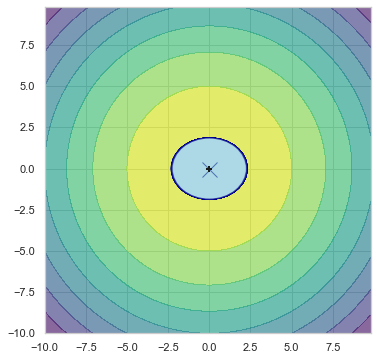

In [28]:
plot_problem_controur(current_problem, ((-10,-10), (10,10)), 
                      optimum=(0,0))
plot_population(pop)

In [29]:
n=500
pop = toolbox.population(n=n)
hof = tools.HallOfFame(1)
start_time=time.time()

pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=n, 
                                         lambda_=n, cxpb=.6,
                                         mutpb=.3, ngen=50, 
                                         stats=stats, 
                                         halloffame=hof, verbose=False)
time_n500=time.time()-start_time

In [30]:
time_n500

0.8338310718536377

<ipython-input-4-ff0702af06c4>:23: UserWarning: The following kwargs were not used by contour: 'rstride', 'cstride', 'linewidth'
  cset = ax.contourf(X, Y, Z, cmap=cmap, rstride=rstride,


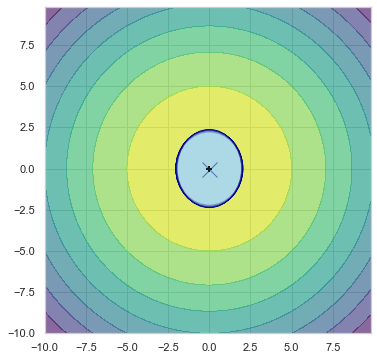

In [31]:
plot_problem_controur(current_problem, ((-10,-10), (10,10)), 
                      optimum=(0,0))
plot_population(pop)

<ipython-input-4-ff0702af06c4>:23: UserWarning: The following kwargs were not used by contour: 'rstride', 'cstride', 'linewidth'
  cset = ax.contourf(X, Y, Z, cmap=cmap, rstride=rstride,


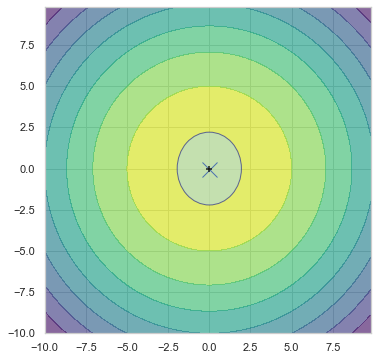

In [32]:
plot_problem_controur(current_problem, ((-10,-10), (10,10)), 
                      optimum=(0,0))
plot_population(hof)

In [33]:
n=1000
pop = toolbox.population(n=n)
hof = tools.HallOfFame(1)
start_time=time.time()

pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=n, 
                                         lambda_=n, cxpb=.6,
                                         mutpb=.3, ngen=50, 
                                         stats=stats, 
                                         halloffame=hof, verbose=False)
time_n1000=time.time()-start_time

In [34]:
time_n1000

1.6061997413635254

<ipython-input-4-ff0702af06c4>:23: UserWarning: The following kwargs were not used by contour: 'rstride', 'cstride', 'linewidth'
  cset = ax.contourf(X, Y, Z, cmap=cmap, rstride=rstride,


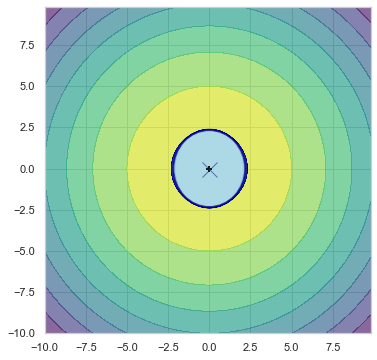

In [35]:
plot_problem_controur(current_problem, ((-10,-10), (10,10)), 
                      optimum=(0,0))
plot_population(pop)

<ipython-input-4-ff0702af06c4>:23: UserWarning: The following kwargs were not used by contour: 'rstride', 'cstride', 'linewidth'
  cset = ax.contourf(X, Y, Z, cmap=cmap, rstride=rstride,


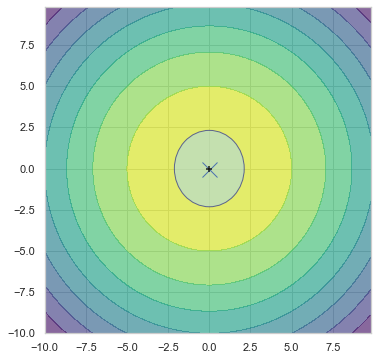

In [36]:
plot_problem_controur(current_problem, ((-10,-10), (10,10)), 
                      optimum=(0,0))
plot_population(hof)

In [37]:
n=10000
pop = toolbox.population(n=n)
hof = tools.HallOfFame(1)
start_time=time.time()

pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=n, 
                                         lambda_=n, cxpb=.6,
                                         mutpb=.3, ngen=50, 
                                         stats=stats, 
                                         halloffame=hof, verbose=False)
time_n10000=time.time()-start_time
time_n10000

18.899950981140137

<ipython-input-4-ff0702af06c4>:23: UserWarning: The following kwargs were not used by contour: 'rstride', 'cstride', 'linewidth'
  cset = ax.contourf(X, Y, Z, cmap=cmap, rstride=rstride,


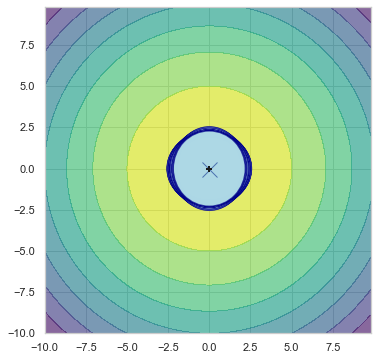

In [38]:
plot_problem_controur(current_problem, ((-10,-10), (10,10)), 
                      optimum=(0,0))
plot_population(pop)

<ipython-input-4-ff0702af06c4>:23: UserWarning: The following kwargs were not used by contour: 'rstride', 'cstride', 'linewidth'
  cset = ax.contourf(X, Y, Z, cmap=cmap, rstride=rstride,


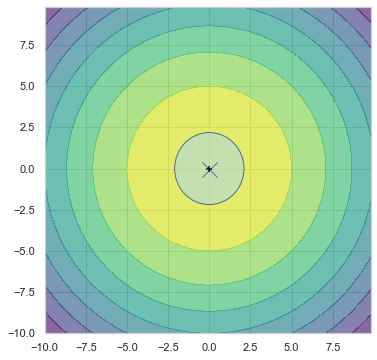

In [39]:
plot_problem_controur(current_problem, ((-10,-10), (10,10)), 
                      optimum=(0,0))
plot_population(hof)